In [1]:
import json
import pandas as pd
import numpy as np
import numexpr as ne
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
from dotenv import load_dotenv
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.cuda.amp as amp

from src.model.model import save_model, load_inference_model
from src.dataset.df import df_dataset, check_dataset
from src.utils.common import set_seed

from src.experiment.inference import inference
from src.experiment.initialize import init_dataset, init_model, init_exp
from src.utils.metrics import compute_surface_dice_score_from_volume
from src.model.model import build_model
from src.model.loss import get_lossfn
from src.utils.metrics import get_metrics
from src.model.scheduler import get_scheduler
from src.dataset.common import get_train_dataset

In [2]:
class cfg:
    debug = False
    check_dataset = True

    # = data CFG ====================================================

    dataset_path = "/kaggle/working/dataset/train01_xy_256_128_z_1_2/"
    train_dataset = "GaussLabelDataset"
    negative_sample_rate = 0.1
    max_distance = 20
    distance_from_edge = 1
    sigma1 = 0.03
    sigma2 = 0.4
    weight = 0.8

    # = experiment CFG =================================================

    project = "SenNet"
    exp_name = os.path.basename(os.getcwd())
    notes = "GaussLabelDataset preliminaly"

    # = model CFG ======================================================

    model_arch = "Unet"
    backbone = "se_resnext50_32x4d"
    in_chans = 1
    target_size = 1

    # = training CFG ===================================================

    epochs = 20

    train_batch_size = 64
    valid_batch_size = train_batch_size

    loss = "DiceLoss"
    metrics = "Dice"
    lr = 5e-4
    num_workers = 12

    # = augmentation ===================================================

    image_size = 256
    train_aug = [
        A.RandomRotate90(p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomResizedCrop(image_size, image_size, scale=(0.8, 1)),
        A.ShiftScaleRotate(p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug = [
        ToTensorV2(transpose_mask=True),
    ]

    # =============== inference ========================================

    test_dataset = "BaseInferenceDataset"
    stride = image_size // 2
    drop_egde_pixel = 32


load_dotenv("/kaggle/key.env")
set_seed()

/tmp/ipykernel_7599/4046888049.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")


image_path  \
0       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
1       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
2       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
3       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
4       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
...                                                   ...   
452169  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452170  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452171  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452172  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452173  /kaggle/working/dataset/cropped_xy_256_128_z_1...   

                                               label_path  \
0       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
1       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
2       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
3       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
4       /kaggle/working/dataset/cropped_xy_256_128_z_1...   
...                                                   ...   
452169  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452170  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452171  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452172  /kaggle/working/dataset/cropped_xy_256_128_z_1...   
452173  /kaggle/working/dataset/cropped_xy_256_128_z_1...   

                                 fname           kidney    x    y    z  std  \
0                x0_y0_z0_std0039_sum0   kidney_1_dense    0    0    0   39   
1              x0_y0_z100_std0037_sum0   kidney_1_dense    0    0  100   37   
2              x0_y0_z102_std0036_sum0   kidney_1_dense    0    0  102   36   
3              x0_y0_z104_std0036_sum0   kidney_1_dense    0    0  104   36   
4              x0_y0_z106_std0036_sum0   kidney_1_dense    0    0  106   36   
...                                ...              ...  ...  ...  ...  ...   
452169  x896_y256_z990_std0261_sum1352  kidney_3_sparse  896  256  990  261   
452170  x896_y256_z992_std0262_sum1473  kidney_3_sparse  896  256  992  262   
452171  x896_y256_z994_std0263_sum1554  kidney_3_sparse  896  256  994  263   
452172  x896_y256_z996_std0264_sum1656  kidney_3_sparse  896  256  996  264   
452173  x896_y256_z998_std0265_sum1830  kidney_3_sparse  896  256  998  265   

         sum  fold0  fold1  
0          0  valid  train  
1          0  valid  train  
2          0  valid  train  
3          0  valid  train  
4          0  valid  train  
...      ...    ...    ...  
452169  1352  train    NaN  
452170  1473  train    NaN  
452171  1554  train    NaN  
452172  1656  train    NaN  
452173  1830  train    NaN  

[452174 rows x 11 columns]

train_len         : 217096
train_image_shape : torch.Size([1, 256, 256])
train_label_shape : torch.Size([1, 256, 256])
train_image_dtype : torch.float32
train_label_dtype : torch.float64

valid_len         : 235078
valid_image_shape : torch.Size([1, 256, 256])
valid_label_shape : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_label_dtype : torch.float64


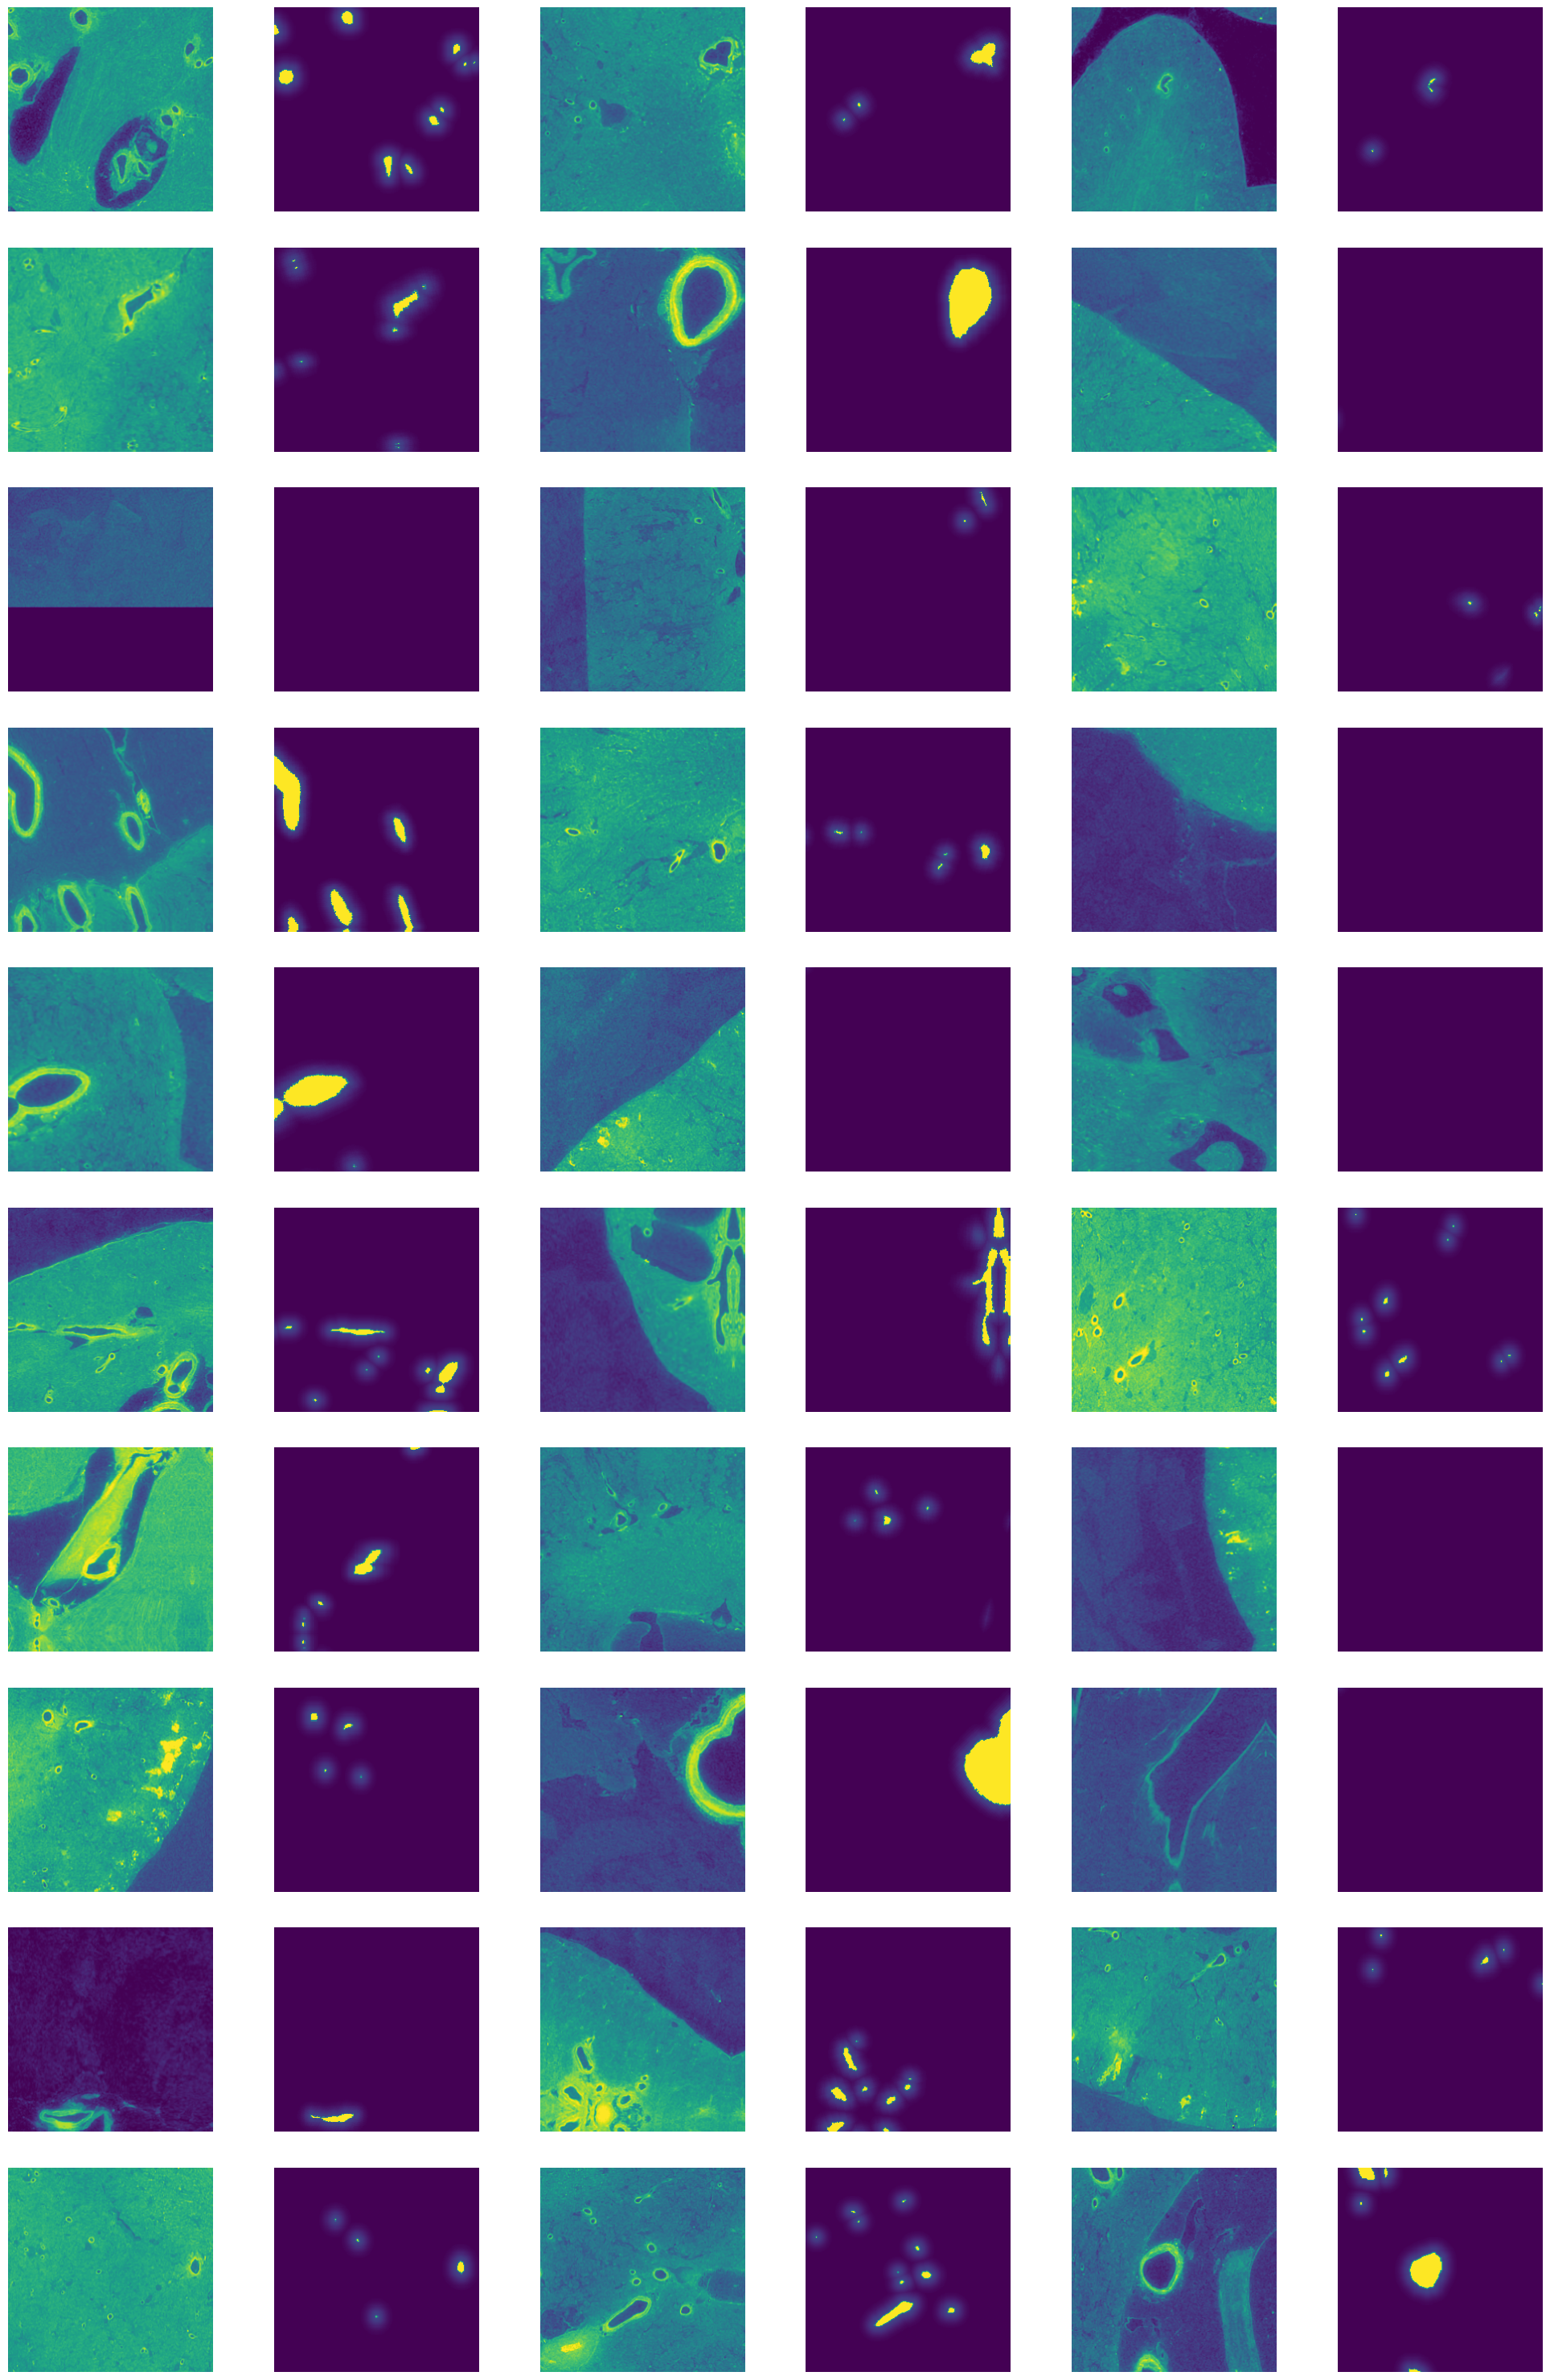

In [3]:
def filter_dataset(df):
    # trainのうちlabelが全くないものは90%の確率で除外
    df["random"] = np.random.rand(len(df))
    df = df[(df["sum"] > 0) | (df["fold0"] == "valid") | (df["random"] < cfg.negative_sample_rate)]
    df = df.reset_index(drop=True)
    df = df.drop(["random"], axis=1)
    return df


df = pd.read_csv(f"{cfg.dataset_path}/dataset.csv")
df = filter_dataset(df)
# df = df.sample(1000).reset_index(drop=True)
if cfg.debug:
    df = df.sample(10000).reset_index(drop=True)
display(df)

if cfg.check_dataset:
    check_dataset(df, cfg)

In [4]:
if cfg.debug:
    print("!!!Debug mode!!!\n")
    cfg.epochs = 5

for fold in range(1):
    dataset = get_train_dataset(cfg)

    train_df = df[df[f"fold{fold}"] == "train"]
    valid_df = df[df[f"fold{fold}"] == "valid"]

    train_dataset = dataset(train_df, cfg, is_train=True)
    valid_dataset = dataset(valid_df, cfg, is_train=False)

    train_dataloader = DataLoader(train_dataset, batch_size=cfg.train_batch_size, num_workers=cfg.num_workers, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.valid_batch_size, num_workers=cfg.num_workers, shuffle=False)

    model = build_model(cfg.model_arch, cfg.backbone, cfg.in_chans, cfg.target_size)
    scaler = torch.cuda.amp.GradScaler()
    criterion = get_lossfn(cfg)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    scheduler = get_scheduler(cfg, optimizer)
    metrics = get_metrics(cfg)

    # model, scaler, criterion, optimizer, scheduler, metrics = init_model(cfg)
    slacknotify = init_exp(fold, cfg)

    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    path_last = f"./{cfg.exp_name}/{cfg.exp_name}_last_fold{fold}.pth"

    best_loss = float("inf")
    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        pbar_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")

        for i, (images, masks) in pbar_train:
            images, masks = images.cuda(), masks.cuda()
            optimizer.zero_grad()

            with amp.autocast():
                preds = model(images)
                loss = criterion(preds, masks)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                total_loss += loss.detach().item()

            loss_ = total_loss / (i + 1)
            lr = f"LR : {scheduler.get_lr()[0]:.2E}"
            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{cfg.epochs}", gpu_mem, lr, f"Loss: {loss_:.4f}"))

        train_loss = loss_
        scheduler.step()
        wandb.log({"epoch": epoch, "train_loss": train_loss})

        model.eval()
        total_loss = 0.0
        pbar_val = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        for i, (images, masks) in pbar_val:
            images, masks = images.cuda(), masks.cuda()
            with torch.no_grad():
                preds = model(images)
                loss = criterion(preds, masks)
                total_loss += loss.item()

            loss_ = total_loss / (i + 1)
            pbar_val.set_description(("%10s") % (f"Val Loss: {loss_:.4f}"))
        valid_loss = loss_
        wandb.log({"epoch": epoch, "valid_loss": valid_loss})

        if valid_loss < best_loss:
            print(f"loss : {valid_loss:.4f}\tSAVED MODEL\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}\tBEST")
            best_loss = valid_loss
            save_model(model, cfg, path_best, loss=loss)
        else:
            print(f"loss : {valid_loss:.4f}\n")
            slacknotify.send_reply(f"epoch : {epoch}\tscore : {valid_loss:.4f}")

    save_model(model, cfg, path_last, loss=valid_loss)
    wandb.config.update({"last_loss": valid_loss, "best_loss": best_loss})

    slacknotify.send_reply(f"{cfg.exp_name}_fold{fold} training finished\nbest loss : {best_loss:.4f} last loss : {loss_:.4f}", True)

    if wandb.run:
        wandb.finish()

model_arch:  Unet
backbone:  se_resnext50_32x4d


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 0/20  Mem : 8.96GB  LR : 5.00E-04  Loss: 0.3695: 100%|██████████| 3393/3393 [10:02<00:00,  5.64it/s]
Val Loss: 0.5135: 100%|██████████| 3674/3674 [06:02<00:00, 10.13it/s]


loss : 0.5135	SAVED MODEL



Epoch 1/20  Mem : 9.97GB  LR : 5.00E-03  Loss: 0.3695: 100%|██████████| 3393/3393 [10:09<00:00,  5.57it/s]
Val Loss: 0.5138: 100%|██████████| 3674/3674 [05:57<00:00, 10.28it/s]


loss : 0.5138



Epoch 2/20  Mem : 9.97GB  LR : 5.00E-04  Loss: 0.3413: 100%|██████████| 3393/3393 [10:08<00:00,  5.58it/s]
Val Loss: 0.5011: 100%|██████████| 3674/3674 [05:57<00:00, 10.28it/s]


loss : 0.5011	SAVED MODEL



Epoch 3/20  Mem : 9.97GB  LR : 4.97E-04  Loss: 0.3378: 100%|██████████| 3393/3393 [10:05<00:00,  5.60it/s]
Val Loss: 0.4919: 100%|██████████| 3674/3674 [05:57<00:00, 10.28it/s]


loss : 0.4919	SAVED MODEL



Epoch 4/20  Mem : 9.97GB  LR : 4.88E-04  Loss: 0.3366: 100%|██████████| 3393/3393 [10:08<00:00,  5.58it/s]
Val Loss: 0.4962: 100%|██████████| 3674/3674 [05:57<00:00, 10.27it/s]


loss : 0.4962



Epoch 5/20  Mem : 9.97GB  LR : 4.73E-04  Loss: 0.3348: 100%|██████████| 3393/3393 [10:06<00:00,  5.59it/s]
Val Loss: 0.4991: 100%|██████████| 3674/3674 [05:57<00:00, 10.26it/s]


loss : 0.4991



Epoch 6/20  Mem : 9.97GB  LR : 4.52E-04  Loss: 0.3351: 100%|██████████| 3393/3393 [10:08<00:00,  5.57it/s]
Val Loss: 0.4908: 100%|██████████| 3674/3674 [05:58<00:00, 10.26it/s]


loss : 0.4908	SAVED MODEL



Epoch 7/20  Mem : 9.97GB  LR : 4.27E-04  Loss: 0.3348: 100%|██████████| 3393/3393 [10:09<00:00,  5.57it/s]
Val Loss: 0.4889: 100%|██████████| 3674/3674 [05:57<00:00, 10.27it/s]


loss : 0.4889	SAVED MODEL



Epoch 8/20  Mem : 9.97GB  LR : 3.97E-04  Loss: 0.3344: 100%|██████████| 3393/3393 [10:09<00:00,  5.57it/s]
Val Loss: 0.4913: 100%|██████████| 3674/3674 [05:57<00:00, 10.27it/s]


loss : 0.4913



Epoch 9/20  Mem : 9.97GB  LR : 3.64E-04  Loss: 0.3340: 100%|██████████| 3393/3393 [10:03<00:00,  5.62it/s]
Val Loss: 0.4835: 100%|██████████| 3674/3674 [05:58<00:00, 10.26it/s]


loss : 0.4835	SAVED MODEL



Epoch 10/20  Mem : 9.97GB  LR : 3.27E-04  Loss: 0.3336: 100%|██████████| 3393/3393 [10:13<00:00,  5.53it/s]
Val Loss: 0.4884: 100%|██████████| 3674/3674 [06:14<00:00,  9.80it/s]


loss : 0.4884



Epoch 11/20  Mem : 9.97GB  LR : 2.89E-04  Loss: 0.3327: 100%|██████████| 3393/3393 [10:24<00:00,  5.44it/s]
Val Loss: 0.4865: 100%|██████████| 3674/3674 [06:00<00:00, 10.20it/s]


loss : 0.4865



Epoch 12/20  Mem : 9.97GB  LR : 2.50E-04  Loss: 0.3330: 100%|██████████| 3393/3393 [10:12<00:00,  5.54it/s]
Val Loss: 0.4895: 100%|██████████| 3674/3674 [05:59<00:00, 10.22it/s]


loss : 0.4895



Epoch 13/20  Mem : 9.97GB  LR : 2.11E-04  Loss: 0.3330: 100%|██████████| 3393/3393 [10:16<00:00,  5.50it/s]
Val Loss: 0.4880: 100%|██████████| 3674/3674 [05:58<00:00, 10.24it/s]


loss : 0.4880



Epoch 14/20  Mem : 9.97GB  LR : 1.73E-04  Loss: 0.3318: 100%|██████████| 3393/3393 [10:15<00:00,  5.52it/s]
Val Loss: 0.4841: 100%|██████████| 3674/3674 [05:59<00:00, 10.23it/s]


loss : 0.4841



Epoch 15/20  Mem : 9.97GB  LR : 1.37E-04  Loss: 0.3325: 100%|██████████| 3393/3393 [10:14<00:00,  5.53it/s]
Val Loss: 0.4837: 100%|██████████| 3674/3674 [05:59<00:00, 10.22it/s]


loss : 0.4837



Epoch 16/20  Mem : 9.97GB  LR : 1.03E-04  Loss: 0.3318: 100%|██████████| 3393/3393 [10:15<00:00,  5.51it/s]
Val Loss: 0.4851: 100%|██████████| 3674/3674 [05:59<00:00, 10.22it/s]


loss : 0.4851



Epoch 17/20  Mem : 9.97GB  LR : 7.33E-05  Loss: 0.3315: 100%|██████████| 3393/3393 [10:31<00:00,  5.37it/s]
Val Loss: 0.4816: 100%|██████████| 3674/3674 [06:26<00:00,  9.52it/s]


loss : 0.4816	SAVED MODEL



Epoch 18/20  Mem : 9.97GB  LR : 4.78E-05  Loss: 0.3320: 100%|██████████| 3393/3393 [10:59<00:00,  5.14it/s]
Val Loss: 0.4823: 100%|██████████| 3674/3674 [06:08<00:00,  9.97it/s]


loss : 0.4823



Epoch 19/20  Mem : 9.97GB  LR : 2.73E-05  Loss: 0.3315: 100%|██████████| 3393/3393 [10:43<00:00,  5.27it/s]
Val Loss: 0.4835: 100%|██████████| 3674/3674 [06:14<00:00,  9.82it/s]


loss : 0.4835



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
fold_dict = json.load(open("/kaggle/src/dataset/fold.json", "r"))

for fold in range(1):
    print(f"fold_{fold}")
    valid_kidney = fold_dict[f"fold{fold}"]["valid"][0]
    path_best = f"./{cfg.exp_name}/{cfg.exp_name}_best_fold{fold}.pth"
    model = load_inference_model(path_best, cfg)

    stack_path = f"/kaggle/working/dataset/stack_train01/{valid_kidney}_images.npy"
    label_path = f"/kaggle/working/dataset/stack_train01/{valid_kidney}_labels.npy"
    save_path = "./preds"
    preds_path = f"{save_path}/{valid_kidney}_preds.npy"
    inference(model, stack_path, save_path, cfg)

    label = np.load(label_path)
    preds = np.load(preds_path)
    thresh_score_dict = {}

    for thresh in np.arange(0.1, 0.99, 0.1):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    max_score_thresh = max(thresh_score_dict, key=thresh_score_dict.get)

    for thresh in np.arange(max_score_thresh - 0.1, max_score_thresh + 0.1, 0.01):
        thresh = round(thresh, 5)
        thresh_score_dict[thresh] = compute_surface_dice_score_from_volume(ne.evaluate("preds > thresh"), label)

    print(max(thresh_score_dict.items(), key=lambda x: x[1]))

fold_0
model_name Unet
backbone se_resnext50_32x4d


100%|██████████| 911/911 [07:25<00:00,  2.05it/s]


(0.51, 0.7946)
